## Inisialisasi 

In [1]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Memuat Data

*Dataset* tersimpan di folder`/datasets/faces/`, yang bisa Anda temukan - Folder `final_file` dengan 7,6 ribu foto 
- File `labels.csv` dengan label, dengan dua kolom: `file_name` dan `real_age` 

Mengingat jumlah file gambarnya cukup banyak, lebih baik hindari membaca semuanya sekaligus, karena akan sangat menghabiskan sumber daya komputasi. Kami sarankan Anda untuk membuat generator dengan ImageDataGenerator. TMetode ini telah dijelaskan sebelumnya di Bab 3, Pelajaran 7. 

Label file bisa dimuat sebagai file CSV biasa.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)

In [4]:
train_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                            directory = '/datasets/faces/final_files',
                                             x_col='file_name',
                                             y_col='real_age',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='raw',
                                             subset='training',
                                             seed=12345)
valid_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                            directory='/datasets/faces/final_files',
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='raw',
                                            subset='validation',
                                            seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [5]:
features_train, target_train = next(train_gen_flow)
features_train.shape

(32, 224, 224, 3)

In [6]:
features_valid, target_valid = next(valid_gen_flow)
features_valid.shape

(32, 224, 224, 3)

## EDA

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

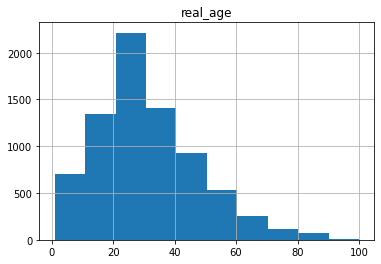

In [8]:
labels.hist()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

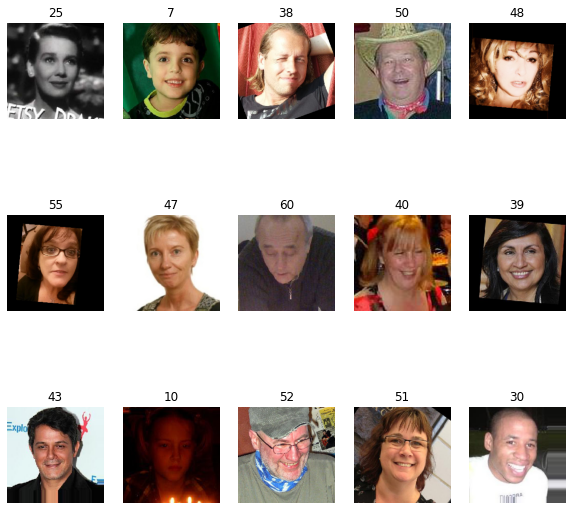

In [10]:
idx = np.random.choice(len(features_train), size=15, replace=False)
images = features_train[idx]
labels = target_train[idx]

plt.figure(figsize=(10, 10))

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")

plt.show()

### Temuan

Dari Eksplorasi data yang sudah dijalankan, didapatkan bahwa

Distribusi umur bisa dikatakan normal, karena memiliki nilai sebagai berikut:\
mean   = 31,2\
modus  = 30\
median = 29

Untuk gambaran secara umum pada gambar, terlihat bahwa ada ada banyak macam gambar dengan berbagai usia dari bayi hingga dewasa, dan juga ada pria maupun wanita.

## Pemodelan 

Tentukan fungsi yang diperlukan untuk melatih model Anda pada platform GPU dan buat skrip tunggal berisi semua fungsi tersebut beserta bagian inisialisasi.

Untuk mempermudah tugas ini, Anda dapat mendefinisikannya dalam *notebook* ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Definisi di bawah ini juga akan diperiksa oleh project reviewer, sehingga mereka dapat memahami cara Anda membangun model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [12]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        shear_range=0.3,
        zoom_range=0.2,
        vertical_flip=True,
        validation_split=0.25,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',

        seed=12345)

    return train_gen_flow

In [13]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [14]:
def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                     include_top=False,
                     classes=1000,
                     weights='imagenet'
                     )
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='relu'))
    optimizer = Adam(0.0002)
    model.compile(optimizer=optimizer, loss='mse', 
                  metrics=['mae'])
    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)


    return model

## Siapkan Skrip untuk menjalankan platform GPU

Setelah menentukan fungsi yang diperlukan, Anda dapat membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Buka...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip harus menyertakan bagian inisialisasi juga. Contohnya ditunjukkan di bawah ini.

In [16]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Didapatkan mae dari dataset validasi adalah 6.869

## Kesimpulan

- Jaringan konvolusional bisa digunakan dalam training model untuk prediksi umur melalui gambar wajah baik pria maupun wanita dengan menggunakan konsep regresi.

- Arsitektur yang digunakan adalah ResNet50

- Untuk membuat model tidak overfitting, digunakan metode data augmentation, khususnya untuk project kali ini yang digunakan adalah vertical flip, shear, dan zoom. Vertical flip adalah gambar akan di mirror secara vertikal, shear adalah gambar seperti di stretch, dan zoom adalah gambar akan dizoom di tempat yang acak.

- Didapatkan Test MAE sebesar 6.8 dengan metode yang dijalankan diatas.